# TAIAOexp

### Generating synthetic image data with g.t. saliency maps: SENECA

Jesús Antoñanzas, under the supervision of Dr. Alvin Jia

<p float="left">
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:300px;"/>
  
  <img src="https://taiao.ai/img/6825_TAIAO_logo_1000x320.jpg" alt="drawing" style="width:250px;"/>
</p>

Let's explore the 'seneca' method for generating artificial images with available ground truth saliency maps. It was presented in [Evaluating local explanation methods on ground truth, Riccardo Guidotti, 2021](https://www.researchgate.net/publication/346916247_Evaluating_local_explanation_methods_on_ground_truth), and although the original intention of the paper was not to present an artificial data generator, it can serve our purpose.

In [1]:
%cd ../../../

/home/ajia/TAIAOexp


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from math import floor

#### 1. Generating the images

Let's generate artificial image data with the 'seneca' method. In this case, the generated images are composed of squared cells of a fixed size and randomly colored as (almost) Red, Green or Blue. A number of these images contain a randomly generated pattern such that the ones that do so are labeled as '1' and the ones that are not are labeled as '0'. If an image contains the pattern, then the ground truth explanation is a binary mask of the same dimensions where the pattern is highlighted. The user can control: 

- Image width and height, in pixels
- Image cell width and height, in pixels and divisor of image width and height
- The proportion of the image that should be filled with cells (fillPct)
- Pattern height and width, in pixels. The number of pixels the randomly generated pattern will take (divisor of image width and height). The previous parameter 'fillPct' also specifies the number of cells filled in the pattern.
- The percentage of images that contain the pattern 'patternProp'
- colorDev: [0, 0.5] If 0, each cell will be completely red, green or blue. The greater (max 0.5), the more mixed will colored channels be. Adds complexity to the task of classification.

In [5]:
from TAIAOexp.saliencyMap import gen_data_sm

nSamples = 100
randomState = 8
imageH, imageW = 32, 32
patternH, patternW = 16, 16
cellH, cellW = 4, 4
patternProp = 0.5
fillPct = 0.4
colorDev = 0.1

X, y, exps, pat = gen_data_sm(nSamples=nSamples, imageH=imageH, imageW=imageW, 
                                 patternH=patternH, patternW=patternW,
                                 cellH=cellH, cellW=cellW, patternProp=patternProp, 
                                 fillPct=fillPct, colorDev=colorDev, randomState=randomState)

**X** contains the generated images, **y** the labels, **exps** the ground truth explanations and **pat** the exact pattern contained by the images.

#### Exploring the images

Some of the generated images contain the following pattern:

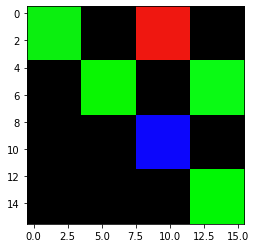

In [6]:
plt.imshow(pat)

For example, the first one, which is labeled as

1


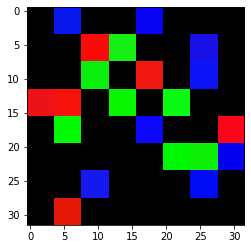

In [7]:
print(y[0])
plt.imshow(X[0])

contains it

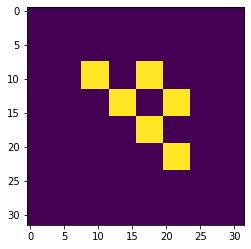

In [8]:
plt.imshow(exps[0])

for a more clear view:

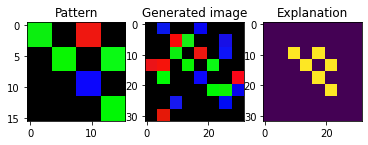

In [9]:
def plt_imgs(p, img, exp):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(p)
    axs[0].set_title('Pattern')
    axs[1].imshow(img)
    axs[1].set_title('Generated image')
    axs[2].imshow(exp)
    axs[2].set_title('Explanation')
    
plt_imgs(pat, X[0], exps[0])

Not all images have the pattern in the same position:plt_imgs(pat, X[0], exps[0])

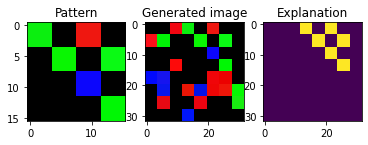

In [10]:
plt_imgs(pat, X[6], exps[6])

We can generate images with another pattern by changing the random state

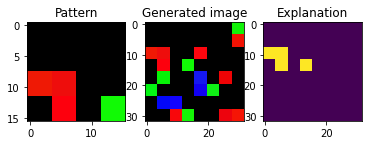

In [11]:
X, y, exps, pat = gen_data_sm(nSamples=100, imageH=imageH, imageW=imageW, 
                                 patternH=patternH, patternW=patternW,
                                 cellH=cellH, cellW=cellW, patternProp=patternProp, 
                                 fillPct=fillPct, colorDev=colorDev, randomState=7)

plt_imgs(pat, X[1], exps[1])

The images that do not contain a pattern have as explanation a black mask. Note that in order for the images to contain the pattern it must not only match the shape, but its colors too. We can check that we have the desired proportion of classes in the dataset:

In [12]:
sum(y) / len(y) == patternProp

True

We can also check how changing the parameter colorDev affects the coloring of the images

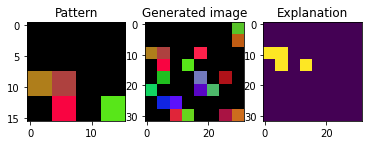

In [13]:
X, y, exps, pat = gen_data_sm(nSamples=100, imageH=imageH, imageW=imageW, 
                                 patternH=patternH, patternW=patternW,
                                 cellH=cellH, cellW=cellW, patternProp=patternProp, 
                                 fillPct=fillPct, colorDev=0.5, randomState=7)

plt_imgs(pat, X[1], exps[1])

Indeed, the pattern and the cells that are filled in the images are the same, but the colors are different.

#### 2. Exploring a white-box model

The 'seneca' method used to generate the artificial data in TAIAOexp can also return an underlying white-box model. In the case of the image data, the model can recognize if the generated pattern is contained within an observation by performing a linear scan. The models implement .fit, .predict and .predict_proba methods in order for them to easily work with explainability frameworks. We can retrieve the whitebox model by setting the parameter 'returnModel' to **True** when generating the data.

In [14]:
X, y, exps, pat, model = gen_data_sm(nSamples=100, imageH=imageH, imageW=imageW, 
                                     patternH=patternH, patternW=patternW,
                                     cellH=cellH, cellW=cellW, patternProp=patternProp, 
                                     fillPct=fillPct, colorDev=0.5, randomState=7, returnModel=True)

In [15]:
model

In [16]:
model.predict(X[:5])

[1, 1, 0, 0, 0]

In [17]:
model.predict_proba(X[:5])

[[0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

The model can also 'explain' instances dynamically:

Text(0.5, 1.0, 'Corresponding image')

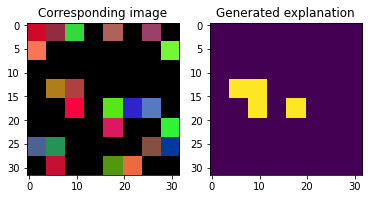

In [18]:
explanations = model.explain(X[:2])

fig, axs = plt.subplots(1, 2)
axs[1].imshow(explanations[0])
axs[1].set_title('Generated explanation')
axs[0].imshow(X[0])
axs[0].set_title('Corresponding image')

and generate explanations for the positive class images:

In [24]:
from TAIAO.utils._explanation import torch_pixel_attributions

# takes a few minutes to run
gradShapExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='gradientShap')
intGradExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='integratedGradient')
deepLiftExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='deepLift')
occlusionExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='occlusion', sliding_window_shapes=(3, cellH, cellW))

/home/ajia/.local/lib/python3.6/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/ajia/.local/lib/python3.6/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


Text(0.5, 1.0, 'occlusion')

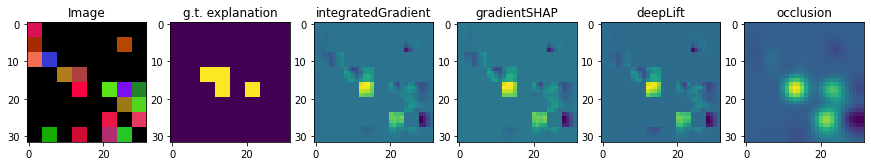

In [25]:
i = 4

fig, axs = plt.subplots(1, 6, figsize=(15,15))
axs[0].imshow(XTrain[yTrain == 1][i].permute(1, 2, 0))
axs[0].set_title('Image')
axs[1].imshow(expsTrain[yTrain == 1][i])
axs[1].set_title('g.t. explanation')
axs[2].imshow(intGradExpsTrain[i])
axs[2].set_title('integratedGradient')
axs[3].imshow(gradShapExpsTrain[i])
axs[3].set_title('gradientSHAP')
axs[4].imshow(deepLiftExpsTrain[i])
axs[4].set_title('deepLift')
axs[5].imshow(occlusionExpsTrain[i])
axs[5].set_title('occlusion')

Finally, we can evaluate the computed explanations for the train set (we can do it for the other sets, too):

In [22]:
from evaluation.image import saliency_map_scores

# ROC AUC, F1Score, precision, recall and cosine similarity
metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']

gradShapScores = []
intGradScores = []
deepLiftScores = []
occlusionScores = []
for i in range(len(XTrain[yTrain == 1])):
    gt = expsTrain[yTrain == 1][i]
    gradShapScores.append(saliency_map_scores(gt, gradShapExpsTrain[i], metrics=metrics, binarizeGt=False))
    intGradScores.append(saliency_map_scores(gt, intGradExpsTrain[i], metrics=metrics, binarizeGt=False))
    deepLiftScores.append(saliency_map_scores(gt, deepLiftExpsTrain[i], metrics=metrics, binarizeGt=False))
    occlusionScores.append(saliency_map_scores(gt, occlusionExpsTrain[i], metrics=metrics, binarizeGt=False))
                          
gradShapScores = np.mean(np.array(gradShapScores), axis=0)
intGradScores = np.mean(np.array(intGradScores), axis=0)
deepLiftScores = np.mean(np.array(deepLiftScores), axis=0)
occlusionScores = np.mean(np.array(occlusionScores), axis=0)

In [23]:
scores = pd.DataFrame(data=[gradShapScores, intGradScores, deepLiftScores, occlusionScores], 
                      columns=metrics)
scores['technique'] = ['gradSHAP', 'intGrad', 'deepLift', 'occlusion']
scores

,auc,fscore,prec,rec,cs,technique
0,0.489231,0.117196,0.062264,0.995251,0.246058,gradSHAP
1,0.481442,0.117204,0.062268,0.995319,0.245174,intGrad
2,0.454612,0.117253,0.062294,0.995732,0.242507,deepLift
3,0.489906,0.117245,0.062290,0.995664,0.238931,occlusion


This whole pipeline has been implemented as a high level function. This function generates artificial image data, splits it into train, val and test, trains the model on the data with the provided training function, generates explanations for the train, validation and test splits with the selected method and evaluates them with the desired metrics:

In [41]:
from evaluation.model import eval_torch_image

import torch

nSamples=1000
metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']
model = FCNN(imageH, imageW, cellH)

intGradtrainScores, intGradvalScores, intGradtestScores = eval_torch_image(model=model,
                                                                           trainFunction=train_net,
                                                                           nSamples=nSamples,
                                                                           imageH=imageH,
                                                                           imageW=imageW,
                                                                           patternH=patternH,
                                                                           patternW=patternW,
                                                                           cellH=cellH,
                                                                           cellW=cellW,
                                                                           dataSplit=(0.7, 0.15, 0.15),
                                                                           expMethod='integratedGradient',
                                                                           metrics=metrics)

Trained model with avg. training loss of 0.0015210037394850092 and avg. training accuracy of 1.0.
Generating explanations with integratedGradient


In [33]:
# occlusion is quite slow, takes a few minutes to compute
occlusiontrainScores, occlusionvalScores, occlusiontestScores = eval_torch_image(model=model,
                                                                                 trainFunction=train_net,
                                                                                 nSamples=nSamples,
                                                                                 imageH=imageH,
                                                                                 imageW=imageW,
                                                                                 patternH=patternH,
                                                                                 patternW=patternW,
                                                                                 cellH=cellH,
                                                                                 cellW=cellW,
                                                                                 dataSplit=(0.7, 0.15, 0.15),
                                                                                 expMethod='occlusion',
                                                                                 sliding_window_shapes=(3, cellH, cellW),
                                                                                 metrics=metrics)

Trained model with avg. training loss of 1.1879716752942344e-06 and avg. training accuracy of 1.0.
Generating explanations with occlusion


In [34]:
gradShaptrainScores, gradShapvalScores, gradShaptestScores = eval_torch_image(model=model,
                                                                              trainFunction=train_net,
                                                                              nSamples=nSamples,
                                                                              imageH=imageH,
                                                                              imageW=imageW,
                                                                              patternH=patternH,
                                                                              patternW=patternW,
                                                                              cellH=cellH,
                                                                              cellW=cellW,
                                                                              dataSplit=(0.7, 0.15, 0.15),
                                                                              expMethod='gradientShap',
                                                                              metrics=metrics)

Trained model with avg. training loss of 9.738275976319115e-07 and avg. training accuracy of 1.0.
Generating explanations with gradientShap


In [35]:
deepLifttrainScores, deepLiftvalScores, deepLifttestScores = eval_torch_image(model=model,
                                                                              trainFunction=train_net,
                                                                              nSamples=nSamples,
                                                                              imageH=imageH,
                                                                              imageW=imageW,
                                                                              patternH=patternH,
                                                                              patternW=patternW,
                                                                              cellH=cellH,
                                                                              cellW=cellW,
                                                                              dataSplit=(0.7, 0.15, 0.15),
                                                                              expMethod='deepLift',
                                                                              metrics=metrics)

Trained model with avg. training loss of 3.749671328989734e-08 and avg. training accuracy of 1.0.
Generating explanations with deepLift


/home/ajia/.local/lib/python3.6/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/ajia/.local/lib/python3.6/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [42]:
scores = pd.DataFrame(data=[intGradtrainScores, occlusiontrainScores, gradShaptrainScores, deepLifttrainScores],
                     columns=metrics)
scores['techniques'] = ['intGrad', 'occlusion', 'gradSHAP', 'deepLift']
scores

,auc,fscore,prec,rec,cs,techniques
0,0.488721,0.144729,0.078024,0.997727,0.274173,intGrad
1,0.466912,0.144729,0.078024,0.997727,0.259132,occlusion
2,0.491650,0.144749,0.078034,0.997864,0.274734,gradSHAP
3,0.487982,0.144742,0.078031,0.997818,0.274769,deepLift


Note that these scores look a bit different to the ones previously shown because the images generated are not the same.